**A CNN model using Keras to classify the IP 102 dataset for an 80/20 train-test split (60).**

### a) Data Preprocessing 

• Sub sample the dataset with enough representation from each class to suit your compute capacity

• Plot the class distribution

• Apply various image augmentation settings

### b) Custom Model 

• Summarize the model architecture

• Explain the hyperparameters used and the reason why they were used.

• Provide an explanation (calculation) of the number of parameters in each layer

• Apply BatchNormalization and Dropouts

• Apply kernel regularization L1 and L2 (kernel_regularizer)

• Plot the drop-in test loss and training loss over epochs

### c) Transfer Learning

• Transfer learn from any three of the models (ResNet, DenseNet, EfficientNet, etc.)

• Freeze most of the layers and train the last few layers on the dataset.

• Compare transfer learning to your best custom model (above) in their accuracy and other metrics.


###Inspect -> console

function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)

In [ ]:
#!pip install natsort==8.2.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from tensorflow import keras
import cv2
from sklearn.metrics import confusion_matrix
#from natsort import os_sorted
from keras.utils import np_utils
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import applications
from keras.models import Sequential, Model 
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

In [ ]:
f = open('/content/drive/MyDrive/CV Project/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CV Project/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('/content/drive/MyDrive/CV Project/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('/content/drive/MyDrive/CV Project/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

test_df.head()
test_df.tail()

,image_path,label
22614,75200.jpg,101
22615,75213.jpg,101
22616,75215.jpg,101
22617,75218.jpg,101
22618,75220.jpg,101


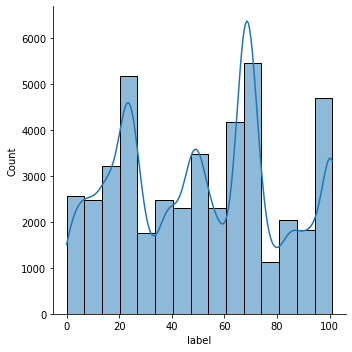

In [ ]:
sns.displot(train_df, x="label", bins=15, kde=True )

In [ ]:
#from pandas.core.internals import concat

#dfs = [train_df, test_df, val_df]  
#df = pd.concat(dfs)
#df,df.columns

In [ ]:
train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac = 0.25, random_state = 1))
train_df

,image_path,label
656,01091.jpg,0
397,00679.jpg,0
304,00514.jpg,0
85,00148.jpg,0
60,00093.jpg,0
...,...,...
42796,71329.jpg,101
43272,72146.jpg,101
42222,70406.jpg,101
42250,70448.jpg,101


In [ ]:
import collections

labels = train_df['label'].to_list()
c = collections.Counter(labels)
#c

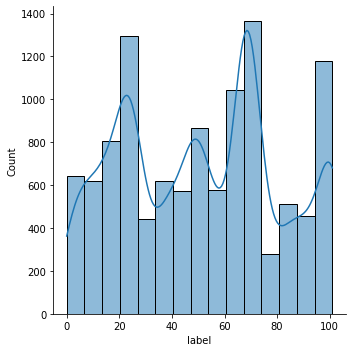

In [ ]:
sns.displot(train_df, x="label", bins=15, kde=True)

In [ ]:
test_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac = 0.10, random_state = 1))
test_df

,image_path,label
80,00282.jpg,0
59,00207.jpg,0
258,00818.jpg,0
284,00912.jpg,0
191,00615.jpg,0
...,...,...
22306,74205.jpg,101
21715,72272.jpg,101
22114,73557.jpg,101
21695,72216.jpg,101


####Distribution preserved

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor
#Passing the path of the image directory
p = Augmentor.Pipeline("/content/drive/MyDrive/CV Project/output")

#Defining augmentation parameters and generating 5 samples
p.flip_left_right(0.5)
p.black_and_white(0.1)
p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(5)


####Dispaying augmented images

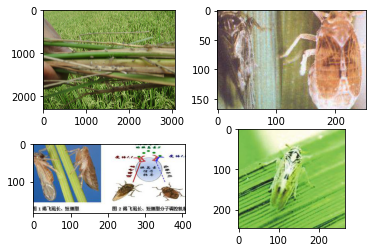

In [ ]:
from matplotlib import pyplot as plt

augment_1 = plt.imread('/content/drive/MyDrive/CV Project/output/04305.jpg')
augment_2 = plt.imread('/content/drive/MyDrive/CV Project/output/04304.jpg')
augment_3 = plt.imread('/content/drive/MyDrive/CV Project/output/04303.jpg')
augment_4 = plt.imread('/content/drive/MyDrive/CV Project/output/04301.jpg')
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(augment_1)
axs[1,0].imshow(augment_2)
axs[0,1].imshow(augment_3)
axs[1,1].imshow(augment_4)
#plt.axis("off")
#plt.show()

In [ ]:
import os

from tensorflow.keras.utils import load_img, save_img
def resize(image_size, dataset_dir):

  for root, dirs, files in os.walk(dataset_dir):
    for i in files:
      if i.endswith('jpg') and not i.startswith ('reduced_images') and not os.path.exists(root + "/reduced_images" + i):
        print(root + "/" + i)
        imgs = load_img(root + "/" + i, target_size=(image_size, image_size), keep_aspect_ratio=True)
        save_img(root + "/reduced_images" + i, imgs)

#resize(128,'/content/drive/MyDrive/CV Project/classification')      

In [ ]:
train_df['label'] = tf.keras.utils.to_categorical(train_df["label"].values, num_classes=102)
#train_df = train_df.drop('label', axis = 1)

In [ ]:
y = train_df['label']

In [ ]:
y.shape

(11270,)

In [ ]:
y_train = y

In [ ]:
y_train = np_utils.to_categorical(y_train, 102)

In [ ]:
y_train.shape

(11270, 102)

In [ ]:
test_df['label'] = tf.keras.utils.to_categorical(test_df["label"].values, num_classes=102)

In [ ]:
y_test = test_df['label']

In [ ]:
y_test.shape

(2263,)

In [ ]:
y_test= np_utils.to_categorical(y_test, 102)

In [ ]:
y_test.shape

(2263, 102)

In [ ]:
image_size = 128

In [ ]:
path = '/content/drive/MyDrive/CV Project/data/test_images/'

In [ ]:
resize(128, '/content/drive/MyDrive/CV Project/data/test_images')

In [ ]:
X = []
for i in range(test_df.shape[0]):
    filenames = test_df['image_path'].iloc[i]
    #try:
    img = image.load_img(path + "reduced_images" + filenames, target_size=(image_size, image_size))
    #except : continue
    X.append(image.img_to_array(img))
    del img

X = np.array(X)  

In [ ]:
X.shape

(2263, 128, 128, 3)

In [ ]:
X_test = X

In [ ]:
print (X_test.shape, y_test.shape)

(2263, 128, 128, 3) (2263, 102)


In [ ]:
image_size = 128

In [ ]:
path = '/content/drive/MyDrive/CV Project/data/train_images/'

Images are resized to 128x128. Using colab and have limited resources.


In [ ]:
resize(128,'/content/drive/MyDrive/CV Project/data/train_images')

In [ ]:
x = []
for i in range(train_df.shape[0]):
    filenames = train_df['image_path'].iloc[i]
    #try:
    img = image.load_img(path + "reduced_images" + filenames, target_size=(image_size, image_size))
    #except : continue
    x.append(image.img_to_array(img))
    del img

x = np.array(x)    

In [ ]:
x.shape

(11270, 128, 128, 3)

In [ ]:
x_train = x

In [ ]:
print(x_train.shape, y_train.shape)

(11270, 128, 128, 3) (11270, 102)


In [ ]:
#def show_final_history(history):
    #fig, ax = plt.subplots(1, 2, figsize=(15,5))
    #ax[0].set_title('loss')
    #ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    #ax[0].plot(history.epoch, history.history["val_loss"], label="Test loss")
    #ax[1].set_title('acc')
    #ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    #ax[1].plot(history.epoch, history.history["val_accuracy"], label="Test accuracy")
    #ax[0].legend()
    #ax[1].legend()

Model Regularization L1

In [ ]:
model_l1 = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.01) ),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True,kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    
    tf.keras.layers.Dense(102, activation='softmax', use_bias=True)
    
])

In [ ]:
model_l1.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_l1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

Conv2D performs 2-dimensional convolution on the images. It takes an input tensor and gives convoluted tensor as output. It takes the following parameters: the number of filters, filter dimension, regularized, and if this is the first layer then the shape of the input, activation function.
MaxPooling2D - ferforms pooling on 2D data. It only needs the shape of the pooling filter. It reduces the shape of the matrix
Dense -  describes a layer of neurons and needs the activation function
Flatten - flattens the data. The output of conv layer is 2D or more, converts them into a unidimensional vector


Regularization is added after layers with the most parameters. It's used to prevent overfitting but controlling the model complexity.In a model each feature is assigned a certain weight, with a lot of features there is large number of weights, which makes the model prone to overfitting. Regularization reduces the burden on these weights. The weights then end up having less impact on the loss function.

Pooling is used after a convolutional layer to compensate for time taken to compute. Also, used to reduce the size of the output from the previous layer.
Only the maximum value of m*m matrix is taken therefore the best features.
ReLU activation is used - it is non-linear around 0, but the slope is always either 0 (for negative values) or 1 (for positive values). For deep learning models ReLU allows for different types of non-linearities to combine ReLU nodes.
Dense layers are used at the end of the network to flatten the multidimensional into a single vector. The number of nodes depends on the number of classes andtThese nodes give the probability of the class of the image.




Calculation:  
kernel size 3x3 * 64 (channels) * 3(input has three channels) + 64(bias) = 1792

Has shape (None,63,63,64) and parameter is 0

64 x 64 3 x 3 (kernel size) + 64 (bias) = 36928

Has shape (None, 30, 30, 64) and parameter is 0  

64 x 128 x (kernel_size) 3 x 3 + 128 (bias) = 73856

Has shape (None, 14, 14, 128) and parameter is  0 

128 x 128 x(kernel_size) 3 x 3 + 128 (bias) = 147584 

Has shape (None, 6, 6, 128) and parameter is  0  

(None, 4608)              0         

input * output + bias = 4608 * 512 + 512 = 2359808   

512 * 102 + 102 = 52326   



In [ ]:
epochs = 10
batch_size=32
history = model_l1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 109s 306ms/step - loss: 421.7176 - accuracy: 0.9816 - val_loss: 378.8118 - val_accuracy: 0.9850
Epoch 2/10
353/353 [==============================] - 106s 300ms/step - loss: 339.3986 - accuracy: 0.9852 - val_loss: 301.1378 - val_accuracy: 0.9850
Epoch 3/10
353/353 [==============================] - 108s 306ms/step - loss: 266.2539 - accuracy: 0.9852 - val_loss: 232.5580 - val_accuracy: 0.9850
Epoch 4/10
353/353 [==============================] - 107s 303ms/step - loss: 202.2222 - accuracy: 0.9852 - val_loss: 173.1019 - val_accuracy: 0.9850
Epoch 5/10
353/353 [==============================] - 110s 312ms/step - loss: 147.3003 - accuracy: 0.9852 - val_loss: 122.7512 - val_accuracy: 0.9850
Epoch 6/10
353/353 [==============================] - 109s 309ms/step - loss: 101.4849 - accuracy: 0.9852 - val_loss: 81.5234 - val_accuracy: 0.9850
Epoch 7/10
353/353 [==============================] - 110s 312ms/step - loss: 64.7930 - accuracy: 0.9

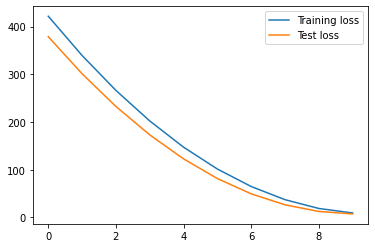

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_l1.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_l1.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 18s 51ms/step - loss: 7.3820 - accuracy: 0.9852
Training Accuracy: 98.52%

71/71 [==============================] - 4s 51ms/step - loss: 7.3761 - accuracy: 0.9850
Testing Accuracy: 98.50%



In [ ]:
predictions = model_l1.predict(X_test)
model_l1.predict(X_test)
y_pred=model_l1.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 4s 50ms/step
[[2229    0]
 [  34    0]]


Model Regularization L2

In [ ]:
model_l2 = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True , kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True,  kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    
    
    tf.keras.layers.Dense(102, activation='softmax', use_bias=True)
    
])

Calculation:  
kernel size 3x3 * 64 (channels) * 3(input has three channels) + 64(bias) = 1792

Has shape (None,63,63,64) and parameter is 0

64 x 64 3 x 3 (kernel size) + 64 (bias) = 36928

Has shape (None, 30, 30, 64) and parameter is 0

64 x 128 x (kernel_size) 3 x 3 + 128 (bias) = 73856

Has shape (None, 14, 14, 128) and parameter is 0

128 x 128 x(kernel_size) 3 x 3 + 128 (bias) = 147584

Has shape (None, 6, 6, 128) and parameter is 0

(None, 4608) 0

input * output + bias = 4608 * 512 + 512 = 2359808

512 * 102 + 102 = 52326

In [ ]:
model_l2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_l2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
epochs=10
batch_size=32
history = model_l2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 109s 308ms/step - loss: 11.7875 - accuracy: 0.9805 - val_loss: 11.2932 - val_accuracy: 0.9850
Epoch 2/10
353/353 [==============================] - 107s 303ms/step - loss: 11.2100 - accuracy: 0.9852 - val_loss: 11.1287 - val_accuracy: 0.9850
Epoch 3/10
353/353 [==============================] - 106s 300ms/step - loss: 11.0514 - accuracy: 0.9852 - val_loss: 10.9711 - val_accuracy: 0.9850
Epoch 4/10
353/353 [==============================] - 106s 299ms/step - loss: 10.8960 - accuracy: 0.9852 - val_loss: 10.8174 - val_accuracy: 0.9850
Epoch 5/10
353/353 [==============================] - 109s 310ms/step - loss: 10.7422 - accuracy: 0.9852 - val_loss: 10.6659 - val_accuracy: 0.9850
Epoch 6/10
353/353 [==============================] - 105s 298ms/step - loss: 10.5908 - accuracy: 0.9852 - val_loss: 10.5170 - val_accuracy: 0.9850
Epoch 7/10
353/353 [==============================] - 108s 305ms/step - loss: 10.4409 - accuracy: 0.9852 - val_l

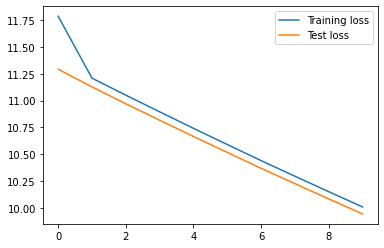

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_l2.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_l2.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 18s 50ms/step - loss: 9.9356 - accuracy: 0.9852
Training Accuracy: 98.52%

71/71 [==============================] - 4s 50ms/step - loss: 9.9433 - accuracy: 0.9850
Testing Accuracy: 98.50%



In [ ]:
predictions = model_l2.predict(X_test)
y_pred=model_l2.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 4s 49ms/step
[[2229    0]
 [  34    0]]


Model Dropout

In [ ]:
model_d = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.Dropout( 0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),    
    tf.keras.layers.Dropout( 0.2), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True),
    tf.keras.layers.Dropout( 0.2),
    
    tf.keras.layers.Dense(102, activation='softmax', use_bias=True)
    
])

In [ ]:
model_d.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                      

Calculation:  

kernel size 3x3 * 64 (channels) * 3(input has three channels) + 64(bias) = 1792

Has shape  (None, 111, 111, 64) and parameter is 0  

64 x 64 x 3 x 3 + 64 = 36928   

Has shape  (None, 54, 54, 64) and parameter is 0  

64 x 128 x 3 x 3 + 128 = 73856 

Has shape  (None, 52, 52, 128) and parameter is  0

Has shape (None, 26, 26, 128) and parameter is  0   

128 x 128 x 3 x 3 + 128 = 147584  

Has shape (None, 24, 24, 128) and parameter is  0

Has shape (None, 12, 12, 128) and parameter is 0

Has shape (None, 18432) and parameter is 0

18432 x 512 + 512 = 9437696   

Has shape (None, 512) and parameter is 0

512 x 3 + 3 = 1539 

In [ ]:
epochs=10
batch_size=32
history = model_d.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 125s 351ms/step - loss: 0.1703 - accuracy: 0.9783 - val_loss: 0.1139 - val_accuracy: 0.9850
Epoch 2/10
353/353 [==============================] - 123s 350ms/step - loss: 0.0800 - accuracy: 0.9852 - val_loss: 0.1018 - val_accuracy: 0.9850
Epoch 3/10
353/353 [==============================] - 122s 345ms/step - loss: 0.0751 - accuracy: 0.9853 - val_loss: 0.0962 - val_accuracy: 0.9850
Epoch 4/10
353/353 [==============================] - 124s 350ms/step - loss: 0.0712 - accuracy: 0.9851 - val_loss: 0.0810 - val_accuracy: 0.9850
Epoch 5/10
353/353 [==============================] - 124s 351ms/step - loss: 0.0694 - accuracy: 0.9848 - val_loss: 0.0803 - val_accuracy: 0.9850
Epoch 6/10
353/353 [==============================] - 122s 347ms/step - loss: 0.0670 - accuracy: 0.9851 - val_loss: 0.0806 - val_accuracy: 0.9850
Epoch 7/10
353/353 [==============================] - 123s 348ms/step - loss: 0.0661 - accuracy: 0.9852 - val_loss: 0.0830 -

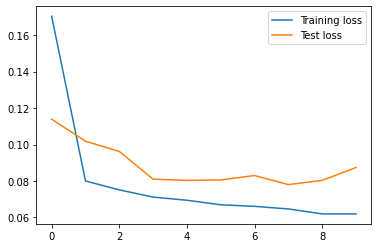

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_d.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_d.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 19s 55ms/step - loss: 0.0812 - accuracy: 0.9852
Training Accuracy: 98.52%

71/71 [==============================] - 4s 57ms/step - loss: 0.0874 - accuracy: 0.9850
Testing Accuracy: 98.50%



In [ ]:
predictions = model_d.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 4s 55ms/step
[[2229    0]
 [  34    0]]


In [ ]:
from tensorflow.keras import layers
IMG_SIZE = 128

In [ ]:
from keras import applications
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers which you don't want to train. 
for layer in model.layers[:20]:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(102, activation="softmax")(x)

model_final = Model(model.input, predictions)

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
epochs = 10 
batch_size=32
history = model_final.fit(x_train, y_train, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 207s 585ms/step - loss: 0.6409 - accuracy: 0.9736 - val_loss: 0.1702 - val_accuracy: 0.9646
Epoch 2/10
353/353 [==============================] - 208s 589ms/step - loss: 0.1009 - accuracy: 0.9846 - val_loss: 0.1163 - val_accuracy: 0.9770
Epoch 3/10
353/353 [==============================] - 207s 587ms/step - loss: 0.0439 - accuracy: 0.9908 - val_loss: 0.1096 - val_accuracy: 0.9823
Epoch 4/10
353/353 [==============================] - 208s 590ms/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 0.1192 - val_accuracy: 0.9841
Epoch 5/10
353/353 [==============================] - 207s 588ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.1191 - val_accuracy: 0.9850
Epoch 6/10
353/353 [==============================] - 207s 585ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.1205 - val_accuracy: 0.9814
Epoch 7/10
353/353 [==============================] - 207s 586ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.1235 -

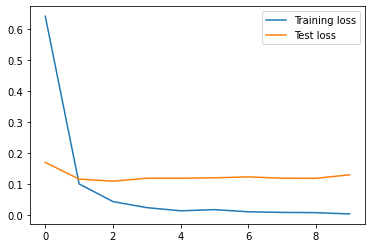

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_final.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_final.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 161s 457ms/step - loss: 2.1180e-04 - accuracy: 1.0000
Training Accuracy: 100.00%

71/71 [==============================] - 32s 452ms/step - loss: 0.1302 - accuracy: 0.9867
Testing Accuracy: 98.67%



In [ ]:
predictions = model_final.predict(X_test)
y_pred=model_final.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 32s 455ms/step
[[2221    8]
 [  22   12]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2229
           1       0.60      0.35      0.44        34

    accuracy                           0.99      2263
   macro avg       0.80      0.67      0.72      2263
weighted avg       0.98      0.99      0.99      2263



In [ ]:
model = applications.EfficientNetB0(weights = "imagenet", include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers[:20]:
    layer.trainable = False

In [ ]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(102, activation="softmax")(x)

model_final_2 = Model(model.input, predictions)

In [ ]:
model_final_2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
epochs = 10
batch_size=32
history = model_final_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 279s 765ms/step - loss: 0.3509 - accuracy: 0.9498 - val_loss: 0.1703 - val_accuracy: 0.9850
Epoch 2/10
353/353 [==============================] - 256s 724ms/step - loss: 0.1217 - accuracy: 0.9852 - val_loss: 0.1369 - val_accuracy: 0.9850
Epoch 3/10
353/353 [==============================] - 258s 731ms/step - loss: 0.0927 - accuracy: 0.9852 - val_loss: 0.1152 - val_accuracy: 0.9850
Epoch 4/10
353/353 [==============================] - 249s 706ms/step - loss: 0.0754 - accuracy: 0.9851 - val_loss: 0.0977 - val_accuracy: 0.9850
Epoch 5/10
353/353 [==============================] - 241s 683ms/step - loss: 0.0650 - accuracy: 0.9851 - val_loss: 0.0845 - val_accuracy: 0.9850
Epoch 6/10
353/353 [==============================] - 257s 728ms/step - loss: 0.0593 - accuracy: 0.9851 - val_loss: 0.0767 - val_accuracy: 0.9850
Epoch 7/10
353/353 [==============================] - 246s 698ms/step - loss: 0.0564 - accuracy: 0.9857 - val_loss: 0.0713 -

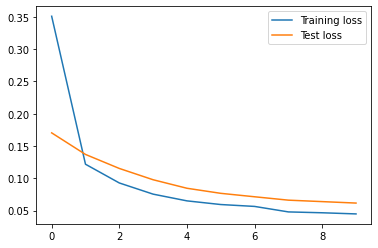

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_final_2.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_final_2.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 52s 146ms/step - loss: 0.0423 - accuracy: 0.9911
Training Accuracy: 99.11%

71/71 [==============================] - 11s 157ms/step - loss: 0.0616 - accuracy: 0.9867
Testing Accuracy: 98.67%



In [ ]:
predictions = model_final_2.predict(X_test)
y_pred=model_final_2.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 10s 144ms/step
[[2229    0]
 [  30    4]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2229
           1       1.00      0.12      0.21        34

    accuracy                           0.99      2263
   macro avg       0.99      0.56      0.60      2263
weighted avg       0.99      0.99      0.98      2263



In [ ]:
model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers which you don't want to train. 
for layer in model.layers[:20]:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(102, activation="softmax")(x)

model_final_3 = Model(model.input, predictions)

In [ ]:
model_final_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
epochs = 10
batch_size=32
history = model_final_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
353/353 [==============================] - 350s 975ms/step - loss: 0.1930 - accuracy: 0.9712 - val_loss: 0.0697 - val_accuracy: 0.9850
Epoch 2/10
353/353 [==============================] - 337s 954ms/step - loss: 0.0564 - accuracy: 0.9859 - val_loss: 0.0555 - val_accuracy: 0.9863
Epoch 3/10
353/353 [==============================] - 327s 925ms/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 0.0520 - val_accuracy: 0.9876
Epoch 4/10
353/353 [==============================] - 335s 950ms/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.0494 - val_accuracy: 0.9876
Epoch 5/10
353/353 [==============================] - 326s 924ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 0.0487 - val_accuracy: 0.9872
Epoch 6/10
353/353 [==============================] - 324s 919ms/step - loss: 0.0164 - accuracy: 0.9942 - val_loss: 0.0485 - val_accuracy: 0.9885
Epoch 7/10
353/353 [==============================] - 328s 928ms/step - loss: 0.0141 - accuracy: 0.9950 - val_loss: 0.0492 -

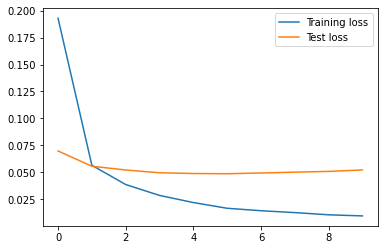

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()

In [ ]:
scores = model_final_3.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model_final_3.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

353/353 [==============================] - 74s 211ms/step - loss: 0.0020 - accuracy: 0.9998
Training Accuracy: 99.98%

71/71 [==============================] - 15s 210ms/step - loss: 0.0521 - accuracy: 0.9876
Testing Accuracy: 98.76%



In [ ]:
predictions = model_final_3.predict(X_test)
y_pred=model_final_3.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
yy_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(yy_test, y_pred)
print(cm)

71/71 [==============================] - 15s 209ms/step
[[2223    6]
 [  22   12]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2229
           1       0.67      0.35      0.46        34

    accuracy                           0.99      2263
   macro avg       0.83      0.68      0.73      2263
weighted avg       0.99      0.99      0.99      2263



The architectures of the custom models are similar so the results for accuracy and confusion matrix output are the same. ResNet50 achieved the highest accuracy from the three transfer learning models. Comparing precision EfficientNet has the highest score. Comparing recall the custom models outperformed the transfer learning models with a score of 98. Recall is low for all transfer learning models affected by the imbalanced distribution of labels.